# In-Depth: k-Means Clustering
Nojus Satikauskas   
C00261186    

## Introduction
Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points. One of the simplest clustering algorithms is the k-means clustering algorithm.

## Theory
The k-means algorithm searches for a predetermined number of clusters within an unlabeled multidimensional dataset. It accomplishes this using the following assumptions:
- The cluster center is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

## Pros and Cons
### Pros
- Simple and easy to understand.
- Fast convergence, especially with a large number of samples.
- Scales well to large datasets.

### Cons
- Requires the number of clusters to be specified in advance.
- Sensitive to initialization, which can lead to convergence to local optima.
- Assumes that clusters are spherical and of similar size.


## Introducing k-Means

The *k*-means algorithm searches for a predetermined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

- The *cluster center* is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly *how* the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization (see the following figure):

### ChangeLog:
The changing the n_samples didnt make a difference in the plot clusters in the graph, but incrementing the centers to 5 and 6 displayed the clusters being more seperated from one another.           
This caused some confusing as to the overlap of blobs and groupings. 

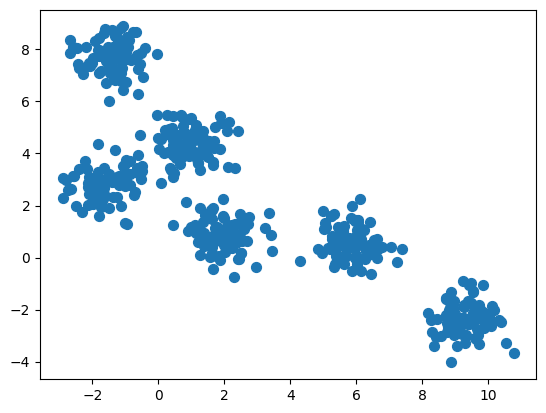

In [90]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=500, centers=6,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [91]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

C:\Users\Nojus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Let's visualize the results by plotting the data colored by these labels (the following figure).
We will also plot the cluster centers as determined by the *k*-means estimator:

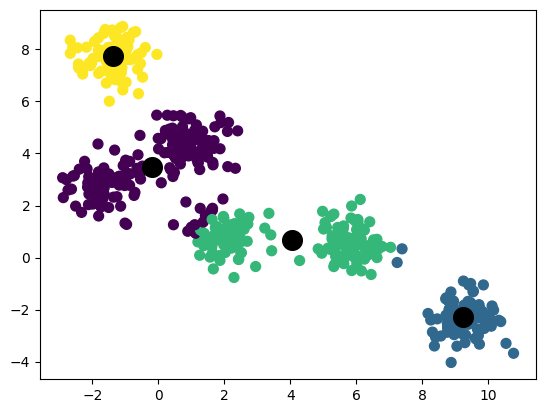

In [92]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200);

The good news is that the *k*-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly: after all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly.
Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to *k*-means involves an intuitive iterative approach known as *expectation–maximization*.

## Expectation–Maximization

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science.
*k*-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here.
In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers.
2. Repeat until converged:
   1. *E-step*: Assign points to the nearest cluster center.
   2. *M-step*: Set the cluster centers to the mean of their assigned points.

Here the *E-step* or *expectation step* is so named because it involves updating our expectation of which cluster each point belongs to.
The *M-step* or *maximization step* is so named because it involves maximizing some fitness function that defines the locations of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

We can visualize the algorithm as shown in the following figure.
For the particular initialization shown here, the clusters converge in just three iterations.
(For an interactive version of this figure, refer to the code in the online [appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Interactive-K-Means).)

![(run code in Appendix to generate image)](images/05.11-expectation-maximization.png)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Expectation-Maximization)

The *k*-means algorithm is simple enough that we can write it in a few lines of code.
The following is a very basic implementation (see the following figure):

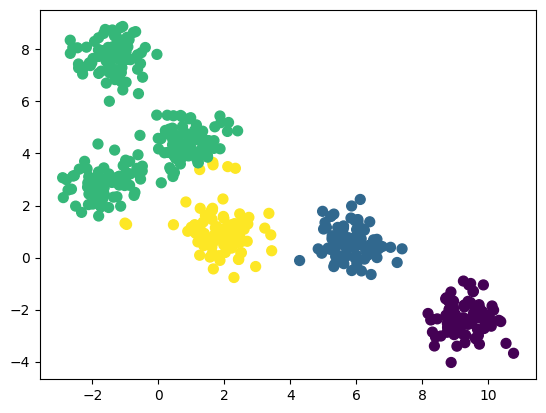

In [93]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Most well-tested implementations will do a bit more than this under the hood, but the preceding function gives the gist of the expectation–maximization approach.

There are a few caveats to be aware of when using the expectation–maximization algorithm:

#### The globally optimal result may not be achieved
First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results (see the following figure):

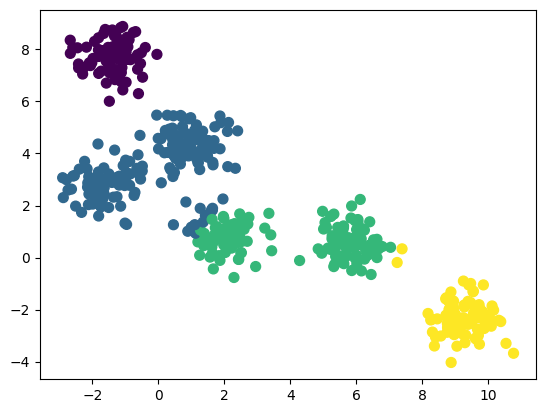

In [94]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (the number is set by the ``n_init`` parameter, which defaults to 10).

#### The number of clusters must be selected beforehand
Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters, as shown in Figure 47-6:

C:\Users\Nojus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


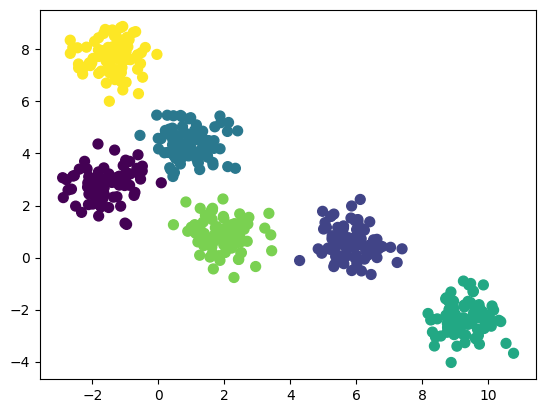

In [95]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we won't discuss further here, is called [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

Alternatively, you might use a more complicated clustering algorithm that has a better quantitative measure of the fitness per number of clusters (e.g., Gaussian mixture models; see [In Depth: Gaussian Mixture Models](05.12-Gaussian-Mixtures.ipynb)) or which *can* choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the `sklearn.cluster` submodule).

#### k-means is limited to linear cluster boundaries
The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between *k*-means clusters will always be linear, which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical *k*-means approach (see the following figure):

In [96]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

C:\Users\Nojus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


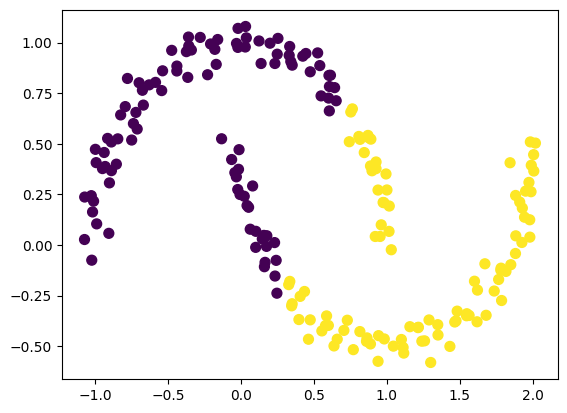

In [97]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

This situation is reminiscent of the discussion in [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb), where we used a kernel transformation to project the data into a higher dimension where a linear separation is possible.
We might imagine using the same trick to allow *k*-means to discover non-linear boundaries.

One version of this kernelized *k*-means is implemented in Scikit-Learn within the ``SpectralClustering`` estimator.
It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a *k*-means algorithm (see the following figure):

C:\Users\Nojus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


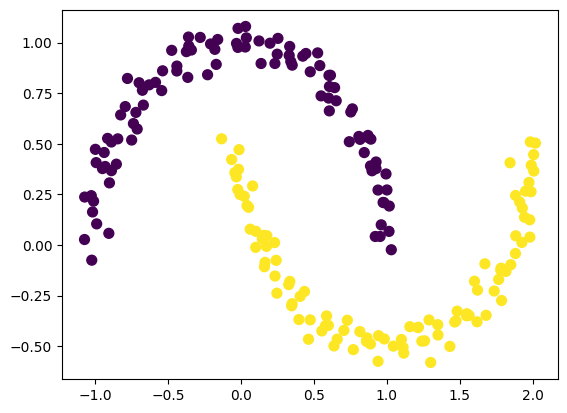

In [98]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

We see that with this kernel transform approach, the kernelized *k*-means is able to find the more complicated nonlinear boundaries between clusters.

#### k-means can be slow for large numbers of samples
Because each iteration of *k*-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows.
You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step.
This is the idea behind batch-based *k*-means algorithms, one form of which is implemented in `sklearn.cluster.MiniBatchKMeans`.
The interface for this is the same as for standard `KMeans`; we will see an example of its use as we continue our discussion.

## Examples

Being careful about these limitations of the algorithm, we can use *k*-means to our advantage in a variety of situations.
We'll now take a look at a couple of examples.

### Example 1: k-Means on Iris

To start, let's take a look at applying *k*-means on the same simple digits data that we saw in [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb) and [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb).
Here we will attempt to use *k*-means to try to identify similar digits *without using the original label information*; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any *a priori* label information.

We will start by loading the dataset, then find the clusters.
Recall that the digits dataset consists of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8 × 8 image:

## Data Preprocessing:
First, we need to load the dataset and perform any necessary preprocessing steps. This includes importing required libraries and loading the dataset:



In [99]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the dataset
df = pd.read_csv("iris.csv")

# Separate features (sepal length, sepal width, petal length, petal width) from the target variable (species)
X = df.drop('Species', axis=1)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Model Training:
Next, we'll train the k-means clustering model on the preprocessed data. We'll choose the number of clusters based on domain knowledge or by using techniques like the elbow method or silhouette score.

In [100]:
# Initialize k-means with the chosen number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model to the scaled data
kmeans.fit(X_scaled)


C:\Users\Nojus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=42)

## Model Evaluation:
To evaluate the quality of the clustering, we can use metrics such as the silhouette score. Higher silhouette scores indicate better clustering.

In [101]:
# Get the cluster labels
cluster_labels = kmeans.labels_

# Compute the silhouette score
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.452949780355554


#### Model was underwelming, making changes in an attempt to improve the Silhouette Score
 

In [102]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the dataset
df = pd.read_csv("iris.csv")

# Separate features (sepal length, sepal width, petal length, petal width) from the target variable (species)
X = df.drop('Species', axis=1)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize variables to track best silhouette score and corresponding number of clusters
best_score = -1
best_n_clusters = None

# Iterate over a range of cluster numbers and find the one with the highest silhouette score
for n_clusters in range(2, 6):  # You can adjust the range as needed
    # Initialize k-means with the current number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    
    # Fit the model to the scaled data
    kmeans.fit(X_scaled)
    
    # Get the cluster labels
    cluster_labels = kmeans.labels_
    
    # Compute the silhouette score
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    
    # Print silhouette score for each cluster number
    print(f"Silhouette Score for {n_clusters} clusters:", silhouette_avg)
    
    # Update best score and number of clusters if needed
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters

# Print the best silhouette score and corresponding number of clusters
print("\nBest Silhouette Score:", best_score)
print("Corresponding Number of Clusters:", best_n_clusters)


C:\Users\Nojus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Nojus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Nojus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

Silhouette Score for 2 clusters: 0.570815210603504
Silhouette Score for 3 clusters: 0.452949780355554
Silhouette Score for 4 clusters: 0.40942326587480654
Silhouette Score for 5 clusters: 0.3271202938118888

Best Silhouette Score: 0.570815210603504
Corresponding Number of Clusters: 2


## Results Visualization:
We can visualize the clustering results to understand how well the model has grouped the data points.

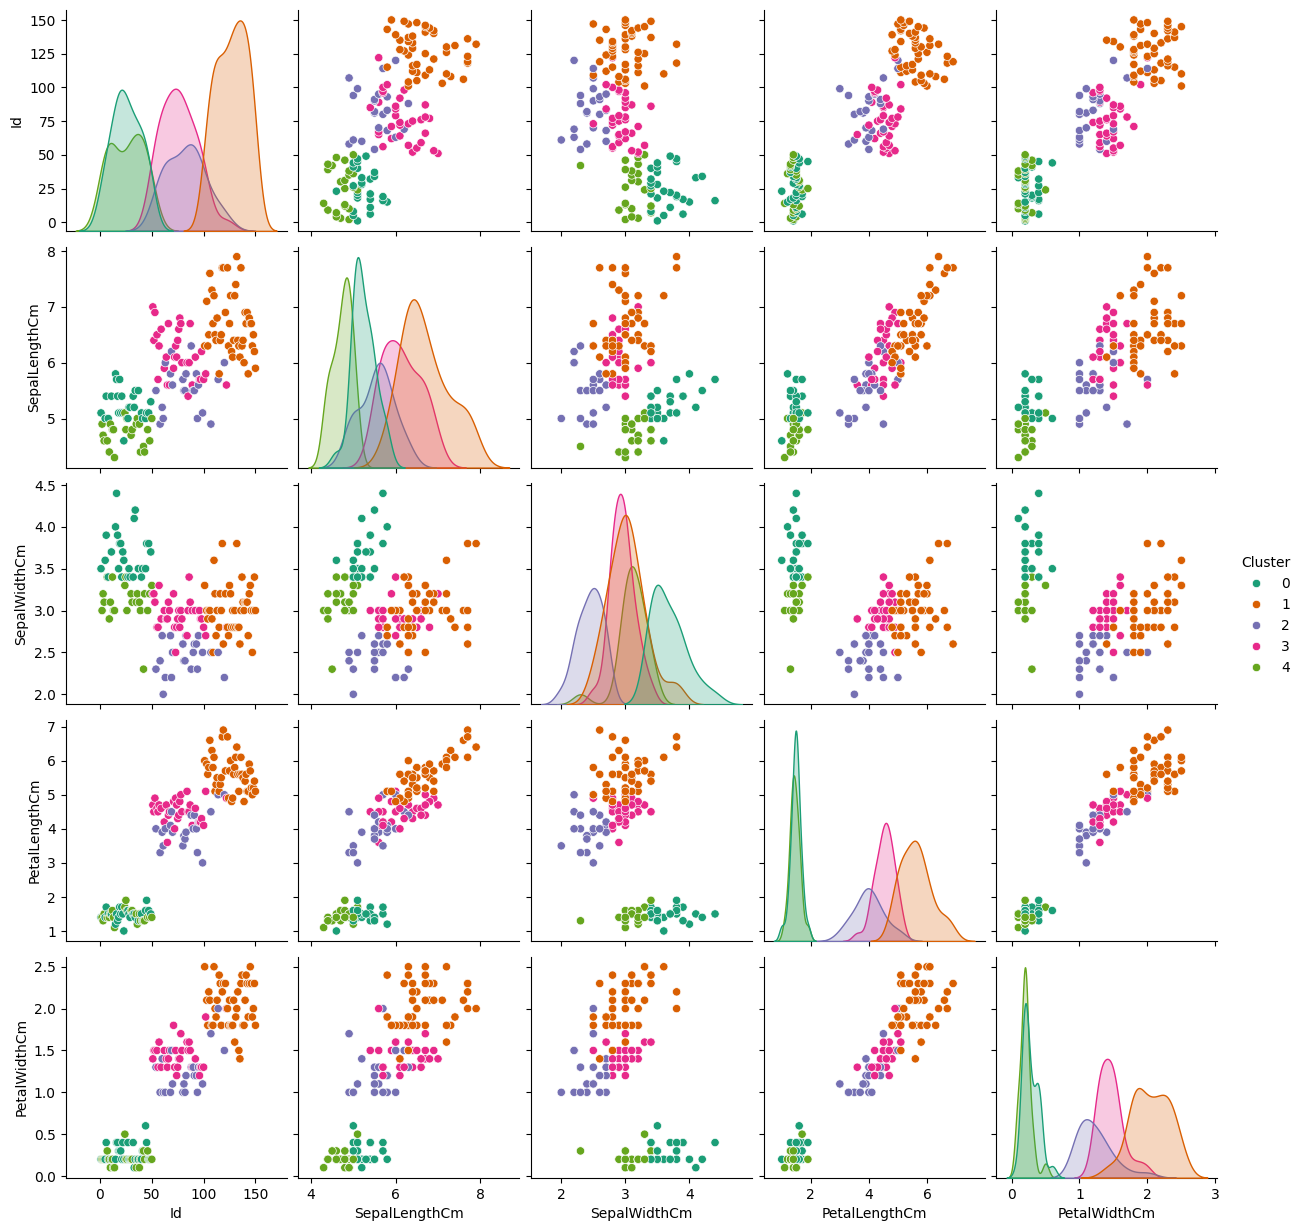

In [103]:
# Add cluster labels to the original dataframe
df['Cluster'] = cluster_labels

# Plot the clusters
import seaborn as sns
sns.pairplot(df, hue='Cluster', palette='Dark2', diag_kind='kde')
plt.show()


## Interpretation:
Finally, we can interpret the results by analyzing the characteristics of each cluster and comparing them with the original species labels if available.



In [104]:
# Analyze cluster centroids
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(cluster_centers, columns=X.columns)
print("Cluster Centroids:")
print(centroids_df)

# Compare with original species labels
original_species_df = df[['Species']]
comparison_df = pd.concat([original_species_df, pd.DataFrame({'Cluster': cluster_labels})], axis=1)
print("\nComparison with Original Species Labels:")
print(comparison_df)


Cluster Centroids:
           Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0   25.481481       5.237037      3.681481       1.477778      0.277778
1  126.888889       6.697778      3.022222       5.624444      2.048889
2   82.727273       5.550000      2.445455       3.995455      1.236364
3   76.363636       6.142424      2.951515       4.533333      1.460606
4   25.521739       4.734783      3.108696       1.447826      0.204348

Comparison with Original Species Labels:
            Species  Cluster
0       Iris-setosa        0
1       Iris-setosa        4
2       Iris-setosa        4
3       Iris-setosa        4
4       Iris-setosa        0
..              ...      ...
145  Iris-virginica        1
146  Iris-virginica        1
147  Iris-virginica        1
148  Iris-virginica        1
149  Iris-virginica        1

[150 rows x 2 columns]


### Example 2: k-Means for Color Compression

One interesting application of clustering is in color compression within images the dataset which I used for this (https://www.kaggle.com/datasets/brendan45774/film-image).    
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

**Loading and preprocessing my jpg file**

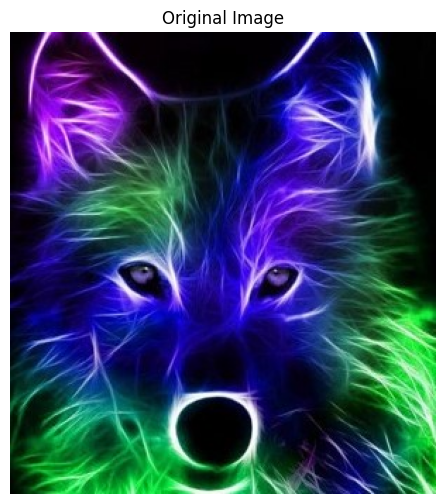

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import MiniBatchKMeans

# Load your own image
image_path = "wolf.jpg"
image = Image.open(image_path)

# Display the original image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

#### Converting the image and reshaping the data, displaying the result 

C:\Users\Nojus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


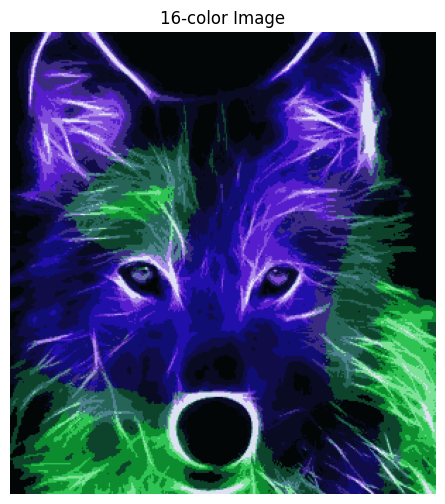

In [106]:
# Convert the image to numpy array
data = np.array(image) / 255.0  # Convert to float and normalize

# Reshape the data
data = data.reshape(-1, 3)

# Perform k-means clustering
num_colors = 16  # You can adjust the number of colors here
kmeans = MiniBatchKMeans(num_colors)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

# Reshape the new colors and the image
new_colors = np.clip(new_colors, 0, 1)  # Clip values to [0, 1]
compressed_image = new_colors.reshape(image.size[1], image.size[0], 3)

# Display the compressed image
plt.figure(figsize=(8, 6))
plt.imshow(compressed_image)
plt.title(f'{num_colors}-color Image')
plt.axis('off')
plt.show()

**Displaying the Mean Squared Error & Silhouette Score**

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error, silhouette_score

image_path = "wolf.jpg"
image = Image.open(image_path)
data = np.array(image) / 255.0
data = data.reshape(-1, 3)

# Perform k-means clustering
num_colors = 16  
kmeans = MiniBatchKMeans(num_colors)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

# Reshape the new colors and the image
new_colors = np.clip(new_colors, 0, 1)  # Clip values to [0, 1]
compressed_image = new_colors.reshape(image.size[1], image.size[0], 3)

# Calculate and display color difference metrics
mse = mean_squared_error(data, new_colors[kmeans.labels_])
print("Mean Squared Error (MSE):", mse)

# Compute silhouette score
silhouette_avg = silhouette_score(data, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)


C:\Users\Nojus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Mean Squared Error (MSE): 0.11314037232322353
Silhouette Score: 0.34241408813284857


## Conclusion:
In conclusion, both examples demonstrate the application of clustering algorithms in different domains. In the first example, clustering is applied to the Iris dataset for species classification, while in the second example, k-means clustering is utilized for color compression in images.

Overall, the results of both examples show that clustering algorithms can effectively partition data into meaningful clusters and compress images by reducing the number of colors. However, the choice of clustering algorithm and parameters, as well as the interpretation of results, may vary depending on the specific application domain and objectives. Further experimentation and evaluation may be necessary to fine-tune the algorithms and achieve optimal performance.